<a href="https://colab.research.google.com/github/benjawad/Cifar10_CNN-/blob/main/Multiclassification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.models import Model, load_model

import numpy as np
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform

In [ ]:

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


In [ ]:
train_images,test_images = tfds.load("cifar10",split=['train', 'test'],shuffle_files=True,as_supervised=True,)

# Normalize pixel values to be between 0 and 1
# train_images =train_images / 255.0
# test_images =  test_images / 255.0


In [ ]:
# Preprocess the dataset
def preprocess_image(image, label):
    image = tf.image.resize(image, (32, 32))  # Resize image to 32x32
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    return image, label

# Apply preprocessing to training dataset
train_images = train_images.map(preprocess_image)
train_images

<_MapDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

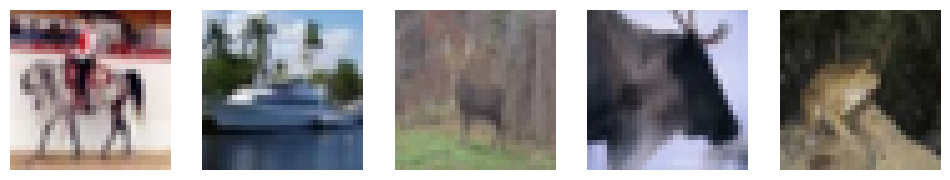

In [ ]:
num_samples = 5
sample_images = []
sample_labels = []

for image, label in train_images.take(num_samples):
    sample_images.append(image.numpy())
    sample_labels.append(label.numpy())

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the sample images
plt.figure(figsize=(12, 8))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    # plt.title(class_names[sample_labels[i][0]])
    plt.axis('off')
plt.show()

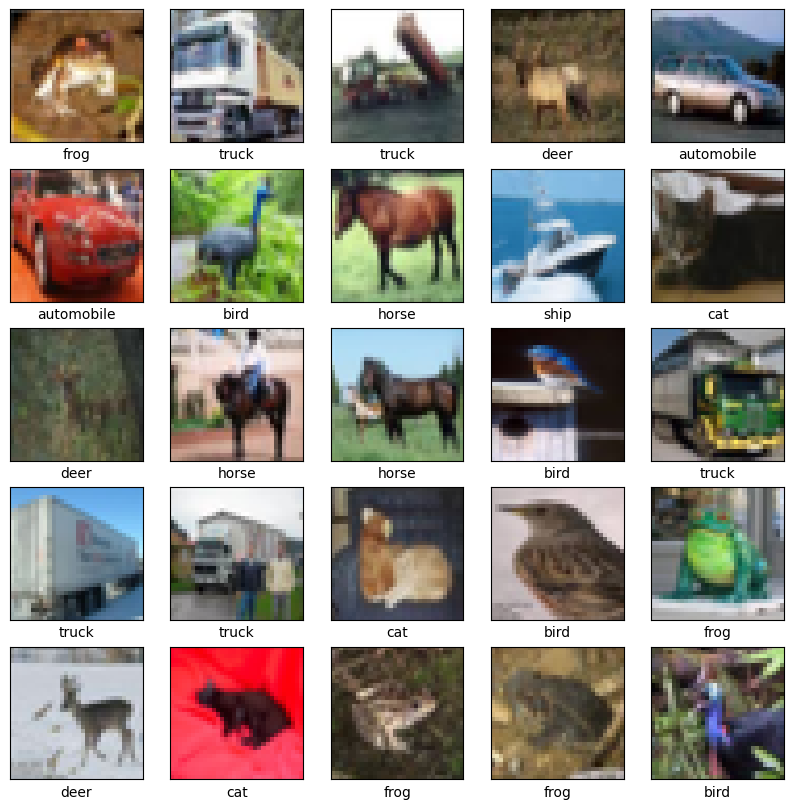

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [ ]:
def identity_block(X, f, filters, stage, block):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###

    return X

In [ ]:
def ResNet50(input_shape = (32, 32, 3), classes = 10):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    # X = AveragePooling2D((2, 2), name='avg_pool')(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [ ]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d_5 (ZeroPadd  (None, 38, 38, 3)            0         ['input_6[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           9472      ['zero_padding2d_5[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']        

In [ ]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

In [ ]:
train_images = train_images.reshape(-1, 32, 32, 3)
test_images = test_images.reshape(-1, 32, 32, 3)

In [ ]:
model.fit(train_images, train_labels, epochs = 5, batch_size = 32)

Epoch 1/5
1563/1563 [==============================] - ETA: 0s

ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [ ]:
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 38, 38, 3)            0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           9472      ['zero_padding2d_4[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']        

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))


In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5690 - accuracy: 0.4293 - val_loss: 1.2815 - val_accuracy: 0.5307
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.2091 - accuracy: 0.5710 - val_loss: 1.1480 - val_accuracy: 0.5875
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0643 - accuracy: 0.6253 - val_loss: 1.0132 - val_accuracy: 0.6429
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9523 - accuracy: 0.6645 - val_loss: 0.9698 - val_accuracy: 0.6541
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8821 - accuracy: 0.6905 - val_loss: 0.9549 - val_accuracy: 0.6627
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8277 - accuracy: 0.7094 - val_loss: 0.9234 - val_accuracy: 0.6777
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7777 - accuracy: 0.7257 - val_loss: 0.8544 - val_ac

313/313 - 1s - loss: 0.8804 - accuracy: 0.7022 - 1s/epoch - 3ms/step


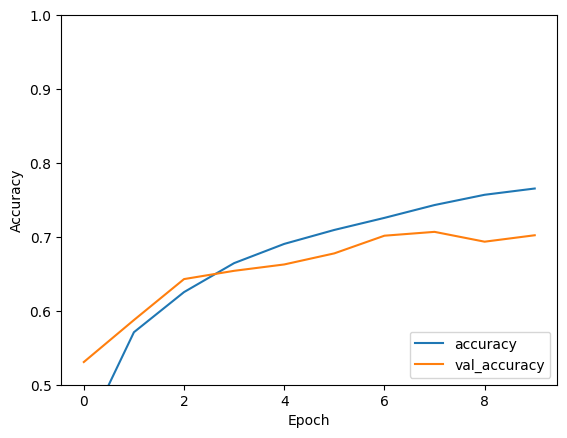

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [ ]:
print(test_acc)


0.7021999955177307


In [ ]:
print("test")

test
